In [268]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import requests
from bs4 import BeautifulSoup
import os
import scipy.stats as st
from statistics import mean, stdev
import zipfile
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

## EDA

In [18]:
colony = pd.read_csv("colony.csv")
stressor = pd.read_csv("stressor.csv")

In [19]:
stressor.head(10)

,year,month,states,stressor,stress_pct
0,2015,January-March,Alabama,Varroa Mites,10.0
1,2015,January-March,Alabama,Diseases,NaN
2,2015,January-March,Alabama,Unknown,9.4
3,2015,January-March,Alabama,Other,9.1
4,2015,January-March,Alabama,Pesticides,2.2
5,2015,January-March,Alabama,Other pests/parasites,5.4
6,2015,January-March,Arizona,Varroa Mites,26.9
7,2015,January-March,Arizona,Diseases,0.1
8,2015,January-March,Arizona,Unknown,3.1
9,2015,January-March,Arizona,Other pests/parasites,20.5


### What is the colony loss percentage per year?

In [20]:
month_mapping = {"January-March":"winter", "April-June":"summer", "July-September":"summer", "October-December":"winter"}
season = colony["month"].map(month_mapping)
colony.insert(3, "season", season)
colony = colony.drop("month", axis=1)

In [21]:
by_year_season = colony[["colony_lost_pct", "year", "season"]].groupby(["season", "year"], as_index=False).mean()
annual = by_year_season[["year", "colony_lost_pct"]].groupby("year", as_index=False).mean()
annual.insert(0, "season", "annual")
by_year_season = pd.concat([by_year_season, annual], ignore_index=True)

In [22]:
by_year_season.tail()

,season,year,colony_lost_pct
19,annual,2018,12.328214
20,annual,2019,11.650327
21,annual,2020,9.917581
22,annual,2021,10.328139
23,annual,2022,9.244444


In [23]:
by_year = by_year_season[by_year_season['season'] == 'annual']
by_year

,season,year,colony_lost_pct
16,annual,2015,12.076570
17,annual,2016,11.437198
18,annual,2017,11.365531
19,annual,2018,12.328214
20,annual,2019,11.650327
21,annual,2020,9.917581
22,annual,2021,10.328139
23,annual,2022,9.244444


## Overall Average Colony Loss Percentage 

1. Colony percentage loss between 2021 and 2022

In [41]:
colony[(colony.year == 2022) | (colony.year == 2021)]['colony_lost_pct'].mean(skipna=True)
data = colony[(colony.year == 2022) | (colony.year == 2021)]['colony_lost_pct'].dropna()
st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data))

10.066666666666666

2. Colony percentage loss before 2021

In [46]:
print(colony[(colony.year != 2022) | (colony.year != 2021)]['colony_lost_pct'].mean(skipna=True))
data = colony[(colony.year != 2022) | (colony.year != 2021)]['colony_lost_pct'].dropna()
st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data))

11.227891156462585


(10.876733694387498, 11.579048618537671)

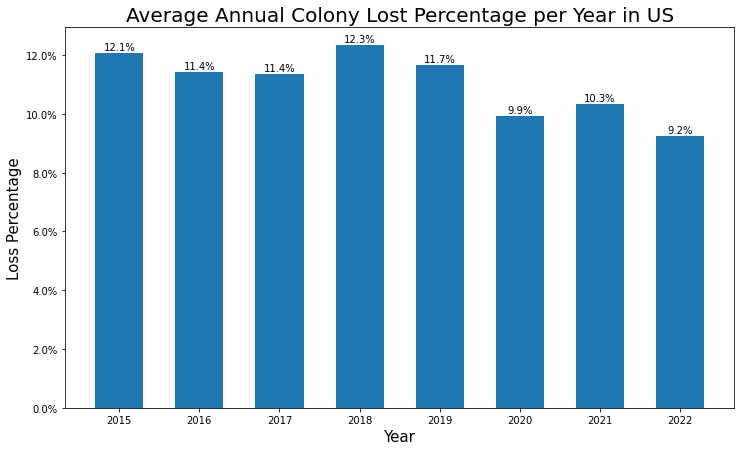

In [24]:
# creating a bar graph with appropriate labels and the title
fig, ax = plt.subplots(1, 1, figsize=(12,7))
b1 = ax.bar(by_year['year'], by_year['colony_lost_pct'], width=0.6)
ax.set_xlabel("Year", fontsize=15)
ax.set_ylabel("Loss Percentage", fontsize=15)
ax.set_title("Average Annual Colony Lost Percentage per Year in US", fontsize=20)

# change the y tick labels
yvals = ax.get_yticks()
ax.set_yticklabels([str(y) + "%" for y in yvals])

# label each bar
for bar in b1:
    height = bar.get_height()
    ax.annotate(f'{str(round(height, 1)) + "%"}',
                   xy=(bar.get_x() + bar.get_width() / 2, height),
                   xytext=(0, 3),
                   textcoords="offset points",
                   ha='center')
plt.show()

### What is the colony loss percentage per season?

In [126]:
print(by_year_season[(by_year_season.year != 2021) | (by_year_season.year != 2022)]['colony_lost_pct'].mean())
data = by_year_season[(by_year_season.year != 2021) | (by_year_season.year != 2022)]['colony_lost_pct'].dropna()
st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data))

11.043500502476954


(10.238339748184318, 11.84866125676959)

In [48]:
seasons = ['summer', 'winter', 'annual']

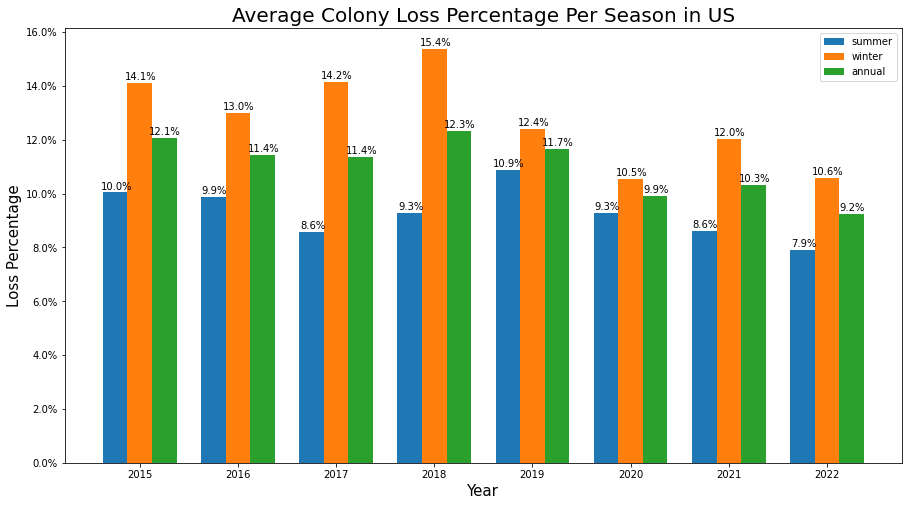

In [161]:
# create figure
fig, ax = plt.subplots(figsize=(15,8))

x = by_year['year']
width = 0.25

summer_bar = ax.bar(x - width, by_year_season[by_year_season['season'] == 'summer']['colony_lost_pct'], width, label='summer')
winter_bar = ax.bar(x, by_year_season[by_year_season['season'] == 'winter']['colony_lost_pct'], width, label='winter')
annual_bar = ax.bar(x + width, by_year_season[by_year_season['season'] == 'annual']['colony_lost_pct'], width, label='annual')

# add appropriate title and labels
ax.set_title("Average Colony Loss Percentage Per Season in US", fontsize=20)
ax.set_xlabel("Year", fontsize=15)
ax.set_ylabel("Loss Percentage", fontsize=15)


# add percentage sign to the y tick label
ax.set_yticklabels([str(l)+"%" for l in ax.get_yticks()])

# add legend
ax.legend()

# annotate each bar
bars = [summer_bar, winter_bar, annual_bar]
for bar in bars:
    for b in bar:
        height = b.get_height()
        ax.annotate(f'{str(round(height, 1)) + "%"}',
                    xy=(b.get_x() + b.get_width() / 2, height),
                    xytext=(1, 3),
                    textcoords="offset points",
                    ha='center')
plt.show()

### Colony Loss Percentage per Season

In [146]:
print(colony[(colony.year==2020) | (colony.year==2021)][colony.season=='summer']['colony_lost_pct'].mean())
data = colony[(colony.year==2020) | (colony.year==2021)][colony.season=='summer']['colony_lost_pct'].dropna()
st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data))

8.958955223880597


(8.147294177007428, 9.770616270753766)

In [147]:
print(colony[(colony.year==2020) | (colony.year==2021)][colony.season=='winter']['colony_lost_pct'].mean())
data = colony[(colony.year==2020) | (colony.year==2021)][colony.season=='winter']['colony_lost_pct'].dropna()
st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data))

11.286764705882353


(10.387132059318668, 12.186397352446038)

In [151]:
# the average loss percentage per season between 2021-2022
summer_2122 = colony[(colony.year==2020) | (colony.year==2021)][colony.season=='summer']['colony_lost_pct']
winter_2122 = colony[(colony.year==2020) | (colony.year==2021)][colony.season=='winter']['colony_lost_pct']

In [179]:
summer_std = stdev(summer_2122.dropna())
winter_std = stdev(winter_2122.dropna())

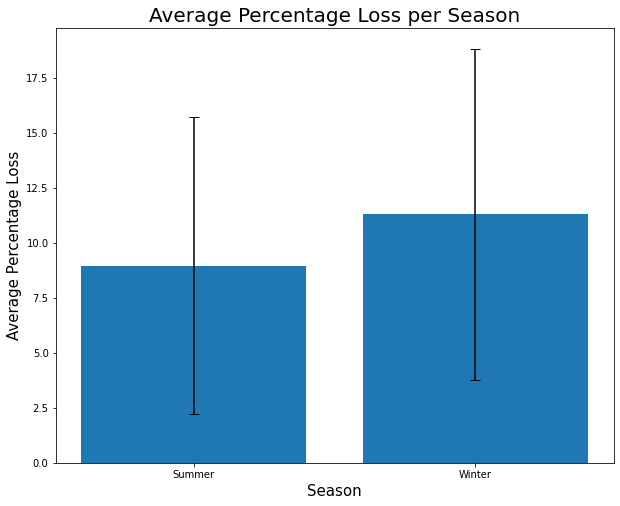

In [197]:
# create the plot
fig, ax = plt.subplots(figsize=(10,8))
plt.bar(['Summer', 'Winter'],[summer_2122.mean(), winter_2122.mean()],yerr=[summer_std, winter_std], capsize=5)
plt.xlabel("Season", size=15)
plt.ylabel("Average Percentage Loss", size=15)
plt.title("Average Percentage Loss per Season", size=20)
plt.show()

In [50]:
# from https://gist.github.com/sfirrin/fd01d87f022d80e98c37a045c14109fe
states_to_regions = {
    'Washington': 'West', 'Oregon': 'West', 'California': 'West', 'Nevada': 'West',
    'Idaho': 'West', 'Montana': 'West', 'Wyoming': 'West', 'Utah': 'West',
    'Colorado': 'West', 'Alaska': 'West', 'Hawaii': 'West', 'Maine': 'Northeast',
    'Vermont': 'Northeast', 'New York': 'Northeast', 'New Hampshire': 'Northeast',
    'Massachusetts': 'Northeast', 'Rhode Island': 'Northeast', 'Connecticut': 'Northeast',
    'New Jersey': 'Northeast', 'Pennsylvania': 'Northeast', 'North Dakota': 'Midwest',
    'South Dakota': 'Midwest', 'Nebraska': 'Midwest', 'Kansas': 'Midwest',
    'Minnesota': 'Midwest', 'Iowa': 'Midwest', 'Missouri': 'Midwest', 'Wisconsin': 'Midwest',
    'Illinois': 'Midwest', 'Michigan': 'Midwest', 'Indiana': 'Midwest', 'Ohio': 'Midwest',
    'West Virginia': 'South', 'District of Columbia': 'South', 'Maryland': 'South',
    'Virginia': 'South', 'Kentucky': 'South', 'Tennessee': 'South', 'North Carolina': 'South',
    'Mississippi': 'South', 'Arkansas': 'South', 'Louisiana': 'South', 'Alabama': 'South',
    'Georgia': 'South', 'South Carolina': 'South', 'Florida': 'South', 'Delaware': 'South',
    'Arizona': 'Southwest', 'New Mexico': 'Southwest', 'Oklahoma': 'Southwest',
    'Texas': 'Southwest', 'Other States': 'other'}

In [51]:
colony_region = colony.states.map(states_to_regions)
colony.insert(3, 'region', colony_region)

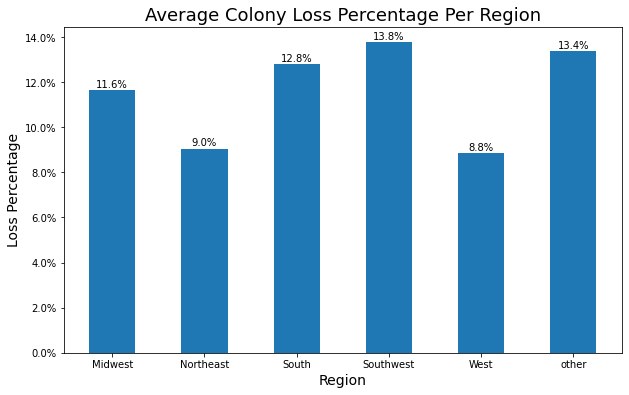

In [53]:
# create a bar plot
fig, ax = plt.subplots(figsize=(10,6))
b = ax.bar(per_region['region'], per_region['colony_lost_pct'], width=0.5)

# add labels
ax.set_title("Average Colony Loss Percentage Per Region", fontsize=18)
ax.set_ylabel("Loss Percentage", fontsize=14)
ax.set_xlabel("Region", fontsize=14)

# edit y tick labels
ax.set_yticklabels([str(l)+"%" for l in ax.get_yticks()])

#label each bar
for bar in b:
    height = bar.get_height()
    ax.annotate(f'{str(round(height, 1)) + "%"}',
                   xy=(bar.get_x() + bar.get_width() / 2, height),
                   xytext=(0, 3),
                   textcoords="offset points",
                   ha='center')

plt.show()

### Do the states that suffered higher colony loss tend to add and renovate more colonies?

In [257]:
# correlation between loss and addition of colonies
df = colony[['colony_lost', 'colony_added']]
df.head()

,colony_lost,colony_added
0,1800.0,2800.0
1,4600.0,3400.0
2,1500.0,1200.0
3,255000.0,250000.0
4,1500.0,200.0


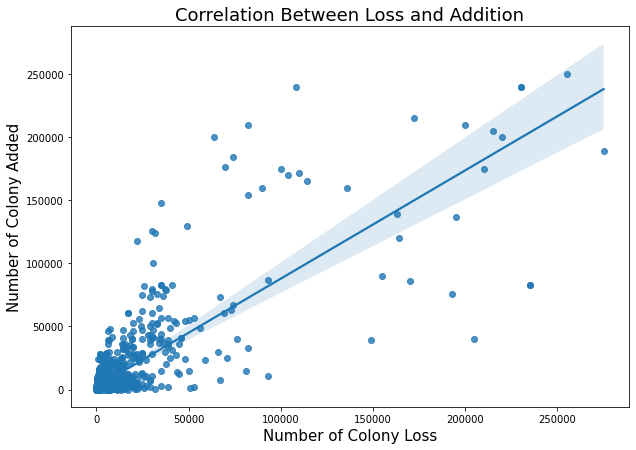

In [258]:
# create a scatter plot
fig, ax = plt.subplots(figsize=(10, 7))

# correlation line with appropriate labels
sns.regplot(df['colony_lost'], df['colony_added'])
ax.set_title("Correlation Between Loss and Addition", fontsize=18)
ax.set_xlabel("Number of Colony Loss", fontsize=15)
ax.set_ylabel("Number of Colony Added", fontsize=15)

plt.show()

In [259]:
df.corr()

,colony_lost,colony_added
colony_lost,1.000000,0.810559
colony_added,0.810559,1.000000


In [260]:
# correlation between loss and renevation of colonies
df = colony[['colony_lost', 'colony_reno']]
df.head()

,colony_lost,colony_reno
0,1800.0,250.0
1,4600.0,2100.0
2,1500.0,90.0
3,255000.0,124000.0
4,1500.0,140.0


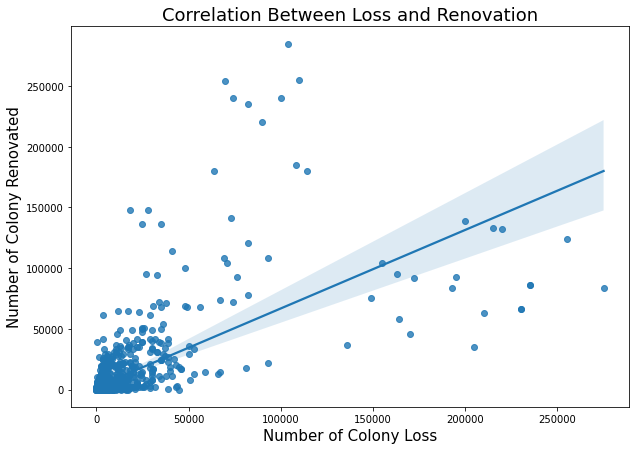

In [262]:
# create a scatter plot
fig, ax = plt.subplots(figsize=(10, 7))

# add appropriate labels
sns.regplot(df['colony_lost'], df['colony_reno'])
ax.set_title("Correlation Between Loss and Renovation", fontsize=18)
ax.set_xlabel("Number of Colony Loss", fontsize=15)
ax.set_ylabel("Number of Colony Renovated", fontsize=15)

plt.show()

In [263]:
df.corr()

,colony_lost,colony_reno
colony_lost,1.000000,0.659655
colony_reno,0.659655,1.000000


States tend to add more colonies rather than renovate them. The correlation between `colony_lost` and `colony_add` is much higher than that of `colony_lost` and `colony_reno`.

### Correlation in the year of 2021-2022

In [250]:
df = colony[['year', 'colony_lost', 'colony_added', 'colony_reno']]
df_2122 = df[(df['year']==2021) | (df['year']==2022)]

In [251]:
# excluding outliers (colony loss greater than 100000)
df_2122 = df_2122[df_2122.colony_lost < 100000]

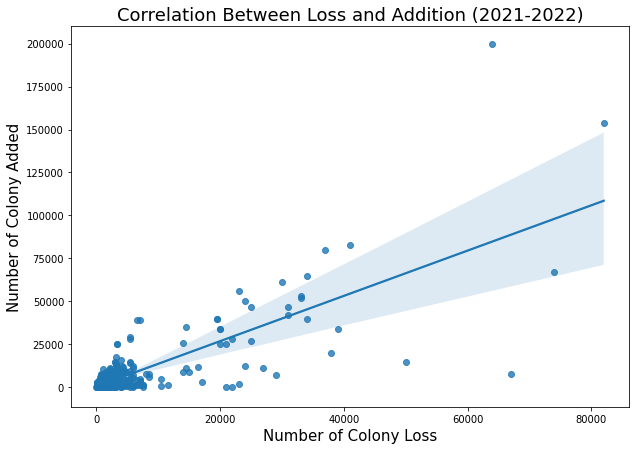

In [252]:
# create a scatter plot
fig, ax = plt.subplots(figsize=(10, 7))

# correlation line with appropriate labels
sns.regplot(df_2122['colony_lost'], df_2122['colony_added'])
ax.set_title("Correlation Between Loss and Addition (2021-2022)", fontsize=18)
ax.set_xlabel("Number of Colony Loss", fontsize=15)
ax.set_ylabel("Number of Colony Added", fontsize=15)

plt.show()

In [253]:
df_2122[['colony_lost', 'colony_added']].corr()

,colony_lost,colony_added
colony_lost,1.000000,0.778836
colony_added,0.778836,1.000000


In [273]:
# from https://zhiyzuo.github.io/Pearson-Correlation-CI-in-Python/
def pearsonr_ci(x,y,alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''

    r, p = st.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = st.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

In [274]:
pearsonr_ci(df_2122['colony_lost'], df_2122['colony_reno'])

(0.7719803679602819,
 1.938430000389672e-72,
 0.7265960398195379,
 0.810657180501259)

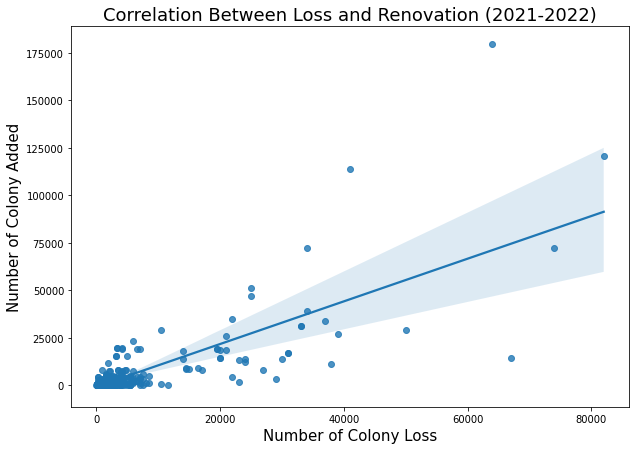

In [254]:
# create a scatter plot
fig, ax = plt.subplots(figsize=(10, 7))

# correlation line with appropriate labels
sns.regplot(df_2122['colony_lost'], df_2122['colony_reno'])
ax.set_title("Correlation Between Loss and Renovation (2021-2022)", fontsize=18)
ax.set_xlabel("Number of Colony Loss", fontsize=15)
ax.set_ylabel("Number of Colony Added", fontsize=15)

plt.show()

In [255]:
df_2122[['colony_lost', 'colony_reno']].corr()

,colony_lost,colony_reno
colony_lost,1.00000,0.77198
colony_reno,0.77198,1.00000


## Stressor

In [60]:
# create season columns using month column
stressor_season = stressor['month'].map(month_mapping)
stressor.insert(2, 'season', stressor_season)
stressor.drop('month', axis=1, inplace=True)

In [61]:
# create region column using states column - using states_to_regions dictionary defined above
stressor_regions = stressor['states'].map(states_to_regions)
stressor.insert(3, 'region', stressor_regions)

In [62]:
stressor.head(10)

,year,season,states,region,stressor,stress_pct
0,2015,winter,Alabama,South,Varroa Mites,10.0
1,2015,winter,Alabama,South,Diseases,NaN
2,2015,winter,Alabama,South,Unknown,9.4
3,2015,winter,Alabama,South,Other,9.1
4,2015,winter,Alabama,South,Pesticides,2.2
5,2015,winter,Alabama,South,Other pests/parasites,5.4
6,2015,winter,Arizona,Southwest,Varroa Mites,26.9
7,2015,winter,Arizona,Southwest,Diseases,0.1
8,2015,winter,Arizona,Southwest,Unknown,3.1
9,2015,winter,Arizona,Southwest,Other pests/parasites,20.5


### What is the distribution of stressors percentage per season?

In [63]:
stressor_by_season = stressor[['season', 'stressor', 'stress_pct']].groupby(['season', 'stressor'], as_index=False).mean('stress_pct')
stressor_by_season

,season,stressor,stress_pct
0,summer,Diseases,4.237500
1,summer,Other,6.810123
2,summer,Other pests/parasites,12.623434
3,summer,Pesticides,7.686340
4,summer,Unknown,3.698062
5,summer,Varroa Mites,32.762878
6,winter,Diseases,3.288540
7,winter,Other,5.556082
8,winter,Other pests/parasites,9.236145
9,winter,Pesticides,4.610857


In [ ]:
# create to different dataframes: one for summer and the other for winter
summer_df = stressor_by_season[stressor_by_season['season']=='summer']
winter_df = stressor_by_season[stressor_by_season['season']=='winter']

In [294]:
# standard deviations
print("stdev: ", stdev(stressor[(stressor.year==2021) | (stressor.year==2022)][stressor.stressor=='Varroa Mites']['stress_pct'].dropna()))
print("mean: ",mean(stressor[(stressor.year==2021) | (stressor.year==2022)][stressor.stressor=='Varroa Mites']['stress_pct'].dropna()))
data = stressor[(stressor.year==2021) | (stressor.year==2022)][stressor.stressor=='Varroa Mites']['stress_pct'].dropna())
st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data))


stdev:  17.032905892629003
mean:  27.334065934065933


(25.578421499024408, 29.08971036910745)

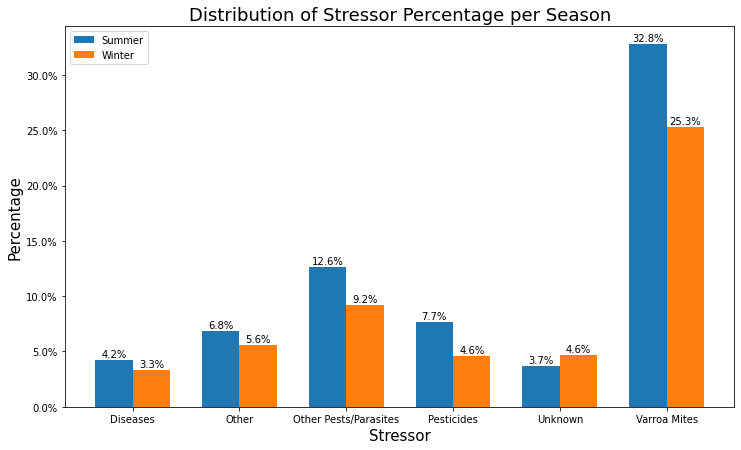

In [340]:
# create plot that contains two bar plots - summer and winter
fig, ax = plt.subplots(figsize=(12,7))
width = 0.35
x = np.arange(len(summer_df['stress_pct']))
labels = ['Diseases', 'Other', 'Other Pests/Parasites', 'Pesticides', 'Unknown', 'Varroa Mites']

# setting grouped bar chart
summer_bar = ax.bar(x-width/2, summer_df['stress_pct'], width, label='Summer')
winter_bar = ax.bar(x+width/2, winter_df['stress_pct'], width, label='Winter')

# set appropriate labels
ax.set_xticks(x, labels)
ax.set_title("Distribution of Stressor Percentage per Season", fontsize=18)
ax.set_xlabel("Stressor", fontsize=15)
ax.set_ylabel("Percentage", fontsize=15)
ax.set_yticklabels([str(l)+"%" for l in ax.get_yticks()])
ax.legend()

# label each bar
for season in [summer_bar, winter_bar]:
    for b in season:
        height = b.get_height()
        ax.annotate(f'{str(round(height, 1)) + "%"}',
                       xy=(b.get_x() + b.get_width() / 2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center')

plt.show()

### What is the distribution of stressors percentage for each region?

In [66]:
stressor_by_region = stressor[['region', 'stressor', 'stress_pct']].groupby(['region', 'stressor'], as_index=False).mean('stress_pct')
stressor_by_region.head(10)

,region,stressor,stress_pct
0,Midwest,Diseases,3.628297
1,Midwest,Other,7.570833
2,Midwest,Other pests/parasites,9.906757
3,Midwest,Pesticides,7.792237
4,Midwest,Unknown,4.945495
5,Midwest,Varroa Mites,27.592918
6,Northeast,Diseases,2.654357
7,Northeast,Other,4.178113
8,Northeast,Other pests/parasites,5.185283
9,Northeast,Pesticides,3.706967


In [67]:
stressor['stressor'].unique()

array(['Varroa Mites', 'Diseases', 'Unknown', 'Other', 'Pesticides',
       'Other pests/parasites'], dtype=object)

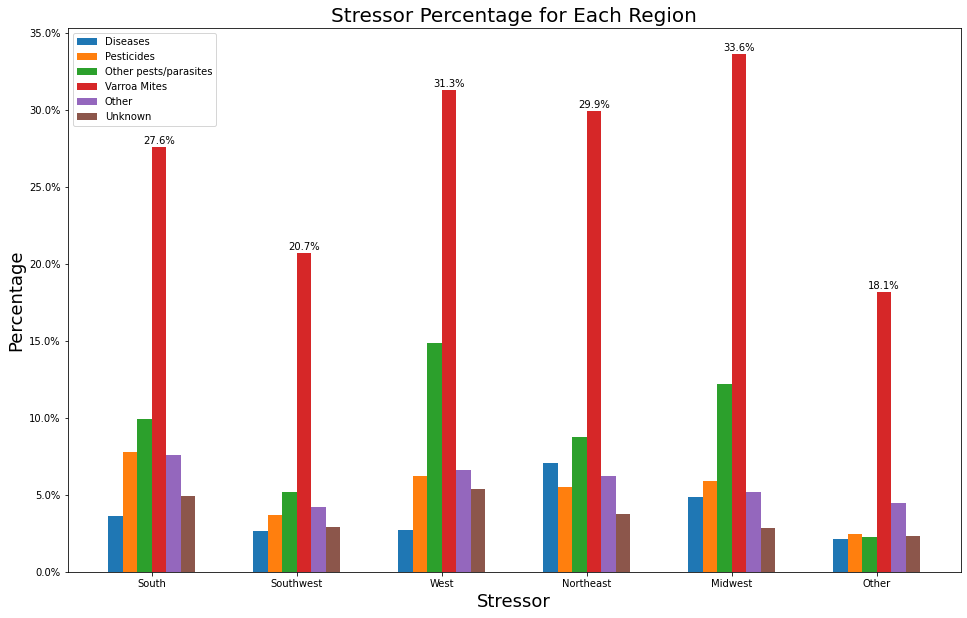

In [345]:
# create and specify bar chart size
fig, ax = plt.subplots(figsize=(16,10))
labels = pd.Series(stressor['region'].unique()).replace({'other':'Other'})
x = np.arange(len(labels))
width = 0.1

# create a grouped bar chart
diseases_bar = ax.bar(x-(width/2)-2*width, stressor_by_region[stressor_by_region['stressor']=='Diseases']['stress_pct'], width, label='Diseases')
pesticides_bar = ax.bar(x-(width/2)-width, stressor_by_region[stressor_by_region['stressor']=='Pesticides']['stress_pct'], width, label='Pesticides')
other_pest_bar = ax.bar(x-(width/2), stressor_by_region[stressor_by_region['stressor']=='Other pests/parasites']['stress_pct'], width, label='Other pests/parasites')
varroa_mite_bar = ax.bar(x+(width/2), stressor_by_region[stressor_by_region['stressor']=='Varroa Mites']['stress_pct'], width, label='Varroa Mites')
other_bar = ax.bar(x+(width/2)+width, stressor_by_region[stressor_by_region['stressor']=='Other']['stress_pct'], width, label='Other')
unknown_bar = ax.bar(x+(width/2)+2*width, stressor_by_region[stressor_by_region['stressor']=='Unknown']['stress_pct'], width, label='Unknown')

# add appropriate labels
ax.set_title('Stressor Percentage for Each Region', fontsize=20)
ax.set_xlabel('Stressor', fontsize=18)
ax.set_ylabel('Percentage', fontsize=18)
ax.legend(loc=2)

# edit tick labels
ax.set_yticklabels([str(l)+'%' for l in ax.get_yticks()])
ax.set_xticks(x, labels)

# only label varroa mite bar
for b in varroa_mite_bar:
    height = b.get_height()
    ax.annotate(f'{str(round(height, 1)) + "%"}',
                       xy=(b.get_x() + b.get_width() / 2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center')

plt.show()

In [69]:
stressor_v2 = pd.pivot_table(stressor, values='stress_pct', index=['year', 'season', 'states'],columns=['stressor']).reset_index().rename_axis(None, axis=1)

In [70]:
# tip: use merge if you are not joining on the index
# joining the two datasets - colony and stressor
merged_df = colony.merge(stressor_v2, on=['year', 'season', 'states'])
merged_df.head(10)

,year,states,season,region,colony_n,colony_max,colony_lost,colony_lost_pct,colony_added,colony_reno,colony_reno_pct,Diseases,Other,Other pests/parasites,Pesticides,Unknown,Varroa Mites
0,2015,Alabama,winter,South,7000.0,7000.0,1800.0,26.0,2800.0,250.0,4.0,0.2,5.95,5.90,1.20,5.65,6.55
1,2015,Alabama,winter,South,8000.0,8000.0,610.0,8.0,80.0,60.0,1.0,0.2,5.95,5.90,1.20,5.65,6.55
2,2015,Arizona,winter,Southwest,35000.0,35000.0,4600.0,13.0,3400.0,2100.0,6.0,0.6,1.15,11.10,3.50,9.30,38.50
3,2015,Arizona,winter,Southwest,36000.0,39000.0,12000.0,31.0,3000.0,16000.0,41.0,0.6,1.15,11.10,3.50,9.30,38.50
4,2015,Arkansas,winter,South,13000.0,14000.0,1500.0,11.0,1200.0,90.0,1.0,0.8,4.75,10.55,5.80,0.80,27.85
5,2015,Arkansas,winter,South,23000.0,27000.0,2400.0,9.0,1900.0,0.0,0.0,0.8,4.75,10.55,5.80,0.80,27.85
6,2015,California,winter,West,1440000.0,1690000.0,255000.0,15.0,250000.0,124000.0,7.0,4.6,8.50,9.95,9.60,5.05,31.00
7,2015,California,winter,West,750000.0,1260000.0,149000.0,12.0,39000.0,75000.0,6.0,4.6,8.50,9.95,9.60,5.05,31.00
8,2015,Colorado,winter,West,3500.0,12500.0,1500.0,12.0,200.0,140.0,1.0,11.5,5.50,12.65,10.15,3.85,31.10
9,2015,Colorado,winter,West,24000.0,24000.0,2500.0,10.0,3400.0,0.0,0.0,11.5,5.50,12.65,10.15,3.85,31.10


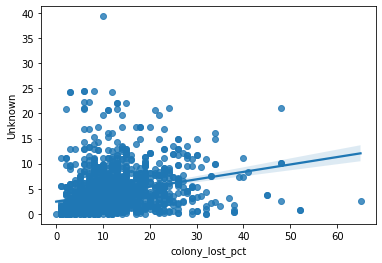

In [71]:
sns.regplot(x=merged_df['colony_lost_pct'], y=merged_df['Unknown'])
plt.show()

In [72]:
merged_df[['colony_lost_pct', 'Unknown']].corr()

,colony_lost_pct,Unknown
colony_lost_pct,1.000000,0.273791
Unknown,0.273791,1.000000


## Colony Loss (Map)

In [73]:
# from https://gist.github.com/rogerallen/1583593

us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}

In [74]:
state_code = merged_df.states.map(us_state_to_abbrev)
merged_df['state_code'] = state_code

In [76]:
merged_df.sort_values('colony_lost_pct', ascending=False)

,year,states,season,region,colony_n,colony_max,colony_lost,colony_lost_pct,colony_added,colony_reno,colony_reno_pct,Diseases,Other,Other pests/parasites,Pesticides,Unknown,Varroa Mites,state_code
1252,2020,Missouri,winter,Midwest,8500.0,8500.0,5500.0,65.0,3400.0,0.0,0.0,0.900000,2.433333,4.900000,1.233333,2.533333,9.966667,MO
762,2018,New Mexico,winter,Southwest,7500.0,7500.0,3900.0,52.0,180.0,0.0,0.0,1.233333,8.933333,0.600000,0.900000,0.733333,55.633333,NM
763,2018,New Mexico,winter,Southwest,7500.0,7500.0,3900.0,52.0,180.0,0.0,0.0,1.233333,8.933333,0.600000,0.900000,0.733333,55.633333,NM
1324,2020,Alabama,summer,South,8500.0,8500.0,4100.0,48.0,4700.0,2600.0,31.0,1.066667,7.066667,21.700000,9.133333,10.233333,40.633333,AL
275,2016,Oklahoma,winter,Southwest,6000.0,6000.0,2900.0,48.0,60.0,510.0,9.0,0.100000,1.133333,1.433333,0.333333,21.066667,6.500000,OK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1347,2020,Hawaii,summer,West,15500.0,15500.0,40.0,NaN,240.0,2300.0,15.0,1.000000,0.900000,48.566667,0.000000,0.000000,49.633333,HI
1545,2021,North Dakota,winter,Midwest,51000.0,65000.0,180.0,NaN,2700.0,0.0,0.0,1.266667,4.650000,0.700000,0.000000,NaN,20.000000,ND
1546,2021,North Dakota,winter,Midwest,51000.0,65000.0,180.0,NaN,2700.0,0.0,0.0,1.266667,4.650000,0.700000,0.000000,NaN,20.000000,ND
1715,2021,Vermont,summer,Northeast,7000.0,7000.0,10.0,NaN,310.0,100.0,1.0,1.000000,1.200000,1.900000,0.000000,0.200000,27.433333,VT


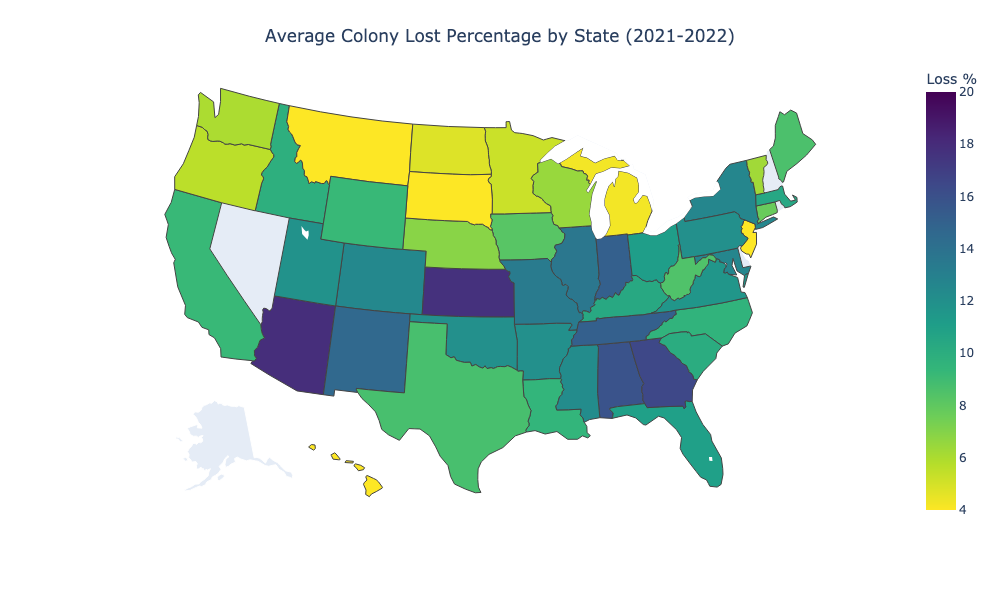

In [339]:
# choropleth map by U.S. States

map_df = merged_df[['state_code', 'colony_lost_pct']][(merged_df.year == 2021) | (merged_df.year == 2022)].groupby('state_code', as_index=False).mean()

fig = px.choropleth(map_df,
                    locations='state_code',
                    locationmode='USA-states',
                    scope='usa',
                    color='colony_lost_pct',
                    range_color=(4,20),
                    color_continuous_scale='Viridis_r',
                    labels={'colony_lost_pct': 'Loss %'})

fig.update_layout(
    title={'text': 'Average Colony Lost Percentage by State (2021-2022)',
           'xanchor': 'center',
           'yanchor': 'top',
           'x': 0.5})

# fig.add_scattergeo(
#   locations = map_df['state_code'],
#   locationmode='USA-states',
#   text = [str(round(x,1))+'%' for x in map_df['colony_lost_pct'] if not pd.isna(x)],
#   mode = 'text')


fig.show(renderer='png', height=600, width=1000)

### Analysis by the States

In [88]:
map_df.sort_values("colony_lost_pct", ascending=False)

,state_code,colony_lost_pct
2,AZ,17.875000
13,KS,17.750000
7,GA,16.500000
0,AL,15.875000
12,IN,15.125000
36,TN,15.125000
28,NM,14.625000
11,IL,13.625000
21,MO,13.375000
29,NY,12.625000


In [336]:
data = merged_df[(merged_df.year == 2021) | (merged_df.year == 2022)][merged_df.states == 'Wyoming']['Varroa Mites']
st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data))

(4.846538397462885, 10.865961602537116)

In [334]:
merged_df[(merged_df.year==2021) | (merged_df.year==2022)][['states', 'Varroa Mites']].groupby('states', as_index=False).mean().sort_values(by='Varroa Mites', ascending=False)

,states,Varroa Mites
8,Hawaii,65.350000
0,Alabama,48.237500
30,Ohio,46.000000
7,Georgia,45.762500
26,New Mexico,42.725000
9,Idaho,41.250000
13,Kansas,40.200000
15,Louisiana,38.887500
35,South Carolina,38.412500
6,Florida,36.962500


In [328]:
data = merged_df[(merged_df.year==2021) | (merged_df.year==2022)][merged_df.states=='Wyoming']['Varroa Mites']
st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data))

(4.846538397462885, 10.865961602537116)

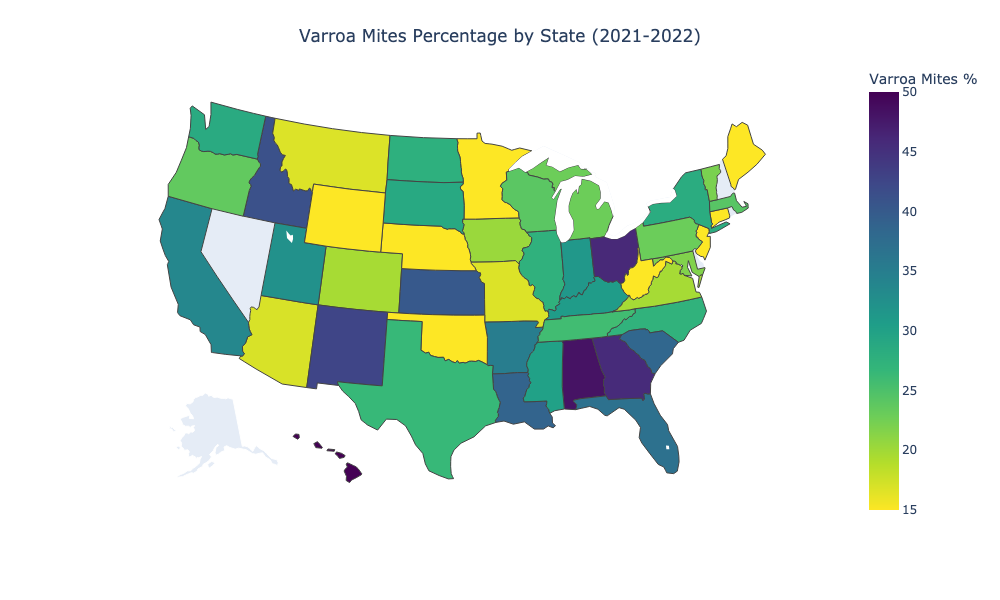

In [346]:
# varroa mite affect over the map in 2021-2022

map_df = merged_df[(merged_df.year==2021) | (merged_df.year==2022)][['state_code', 'Varroa Mites']].groupby('state_code', as_index=False).mean()

fig = px.choropleth(map_df,
                    locations='state_code',
                    locationmode='USA-states',
                    scope='usa',
                    color='Varroa Mites',
                    range_color=(15,50),
                    color_continuous_scale='Viridis_r',
                    labels={'Varroa Mites': 'Varroa Mites %'})

fig.update_layout(
    title={'text': 'Varroa Mites Percentage by State (2021-2022)',
           'xanchor': 'center',
           'yanchor': 'top',
           'x': 0.5})

# fig.add_scattergeo(
#   locations = map_df['state_code'],
#   locationmode='USA-states',
#   text = [str(round(x,1))+'%' for x in map_df['colony_lost_pct'] if not pd.isna(x)],
#   mode = 'text')


fig.show(renderer='png', height=600, width=1000)

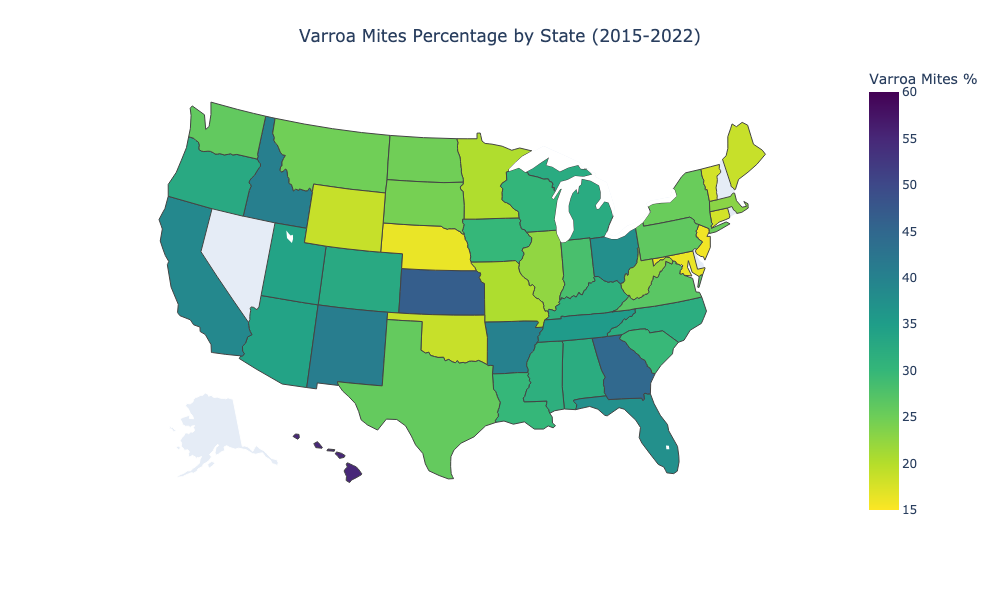

In [309]:
# varroa mite affect over the map

map_df = merged_df[['state_code', 'Varroa Mites']].groupby('state_code', as_index=False).mean()

fig = px.choropleth(map_df,
                    locations='state_code',
                    locationmode='USA-states',
                    scope='usa',
                    color='Varroa Mites',
                    range_color=(15,60),
                    color_continuous_scale='Viridis_r',
                    labels={'Varroa Mites': 'Varroa Mites %'})

fig.update_layout(
    title={'text': 'Varroa Mites Percentage by State (2015-2022)',
           'xanchor': 'center',
           'yanchor': 'top',
           'x': 0.5})

# fig.add_scattergeo(
#   locations = map_df['state_code'],
#   locationmode='USA-states',
#   text = [str(round(x,1))+'%' for x in map_df['colony_lost_pct'] if not pd.isna(x)],
#   mode = 'text')


fig.show(renderer='png', height=600, width=1000)